In [1]:
from sklearn.preprocessing import FunctionTransformer

from reskit.norms import binar_norm
from reskit.norms import spectral_norm, wbysqdist

from reskit.core import Transformer, Pipeliner

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import StratifiedKFold

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

import os
import pandas as pd
import numpy as np

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def orig(x):
    return x

import matrix_eig as me

from matplotlib import pyplot as plt
%matplotlib inline
import re

In [2]:
def get_autism(path_to_read='../Data/dti/', distances=True):
    def get_autism_distances(loc_name):
        with open(loc_name, 'r') as f:
            read_data = f.readlines()

        read_data = pd.DataFrame(
            np.array([np.array(item[:-1].split()).astype(int) for item in read_data]))

        return read_data

    def get_distance_matrix(coords):
        if type(coords) == pd.core.frame.DataFrame:
            coords = coords.values
        elif type(coords) != np.ndarray:
            print('Provide either pandas df or numpy array!')
            return -1

        shape = len(coords)
        dist_matrix = np.zeros((shape, shape))
        del shape
        for i in range(len(coords)):
            for j in range(i + 1, len(coords)):
                dist_matrix[i, j] = np.linalg.norm(coords[i, :] - coords[j, :])
                dist_matrix[j, i] = dist_matrix[i, j]
        return dist_matrix

    target_vector = []  # this will be a target vector (diagnosis)
    matrices = []  # this will be a list of connectomes
    all_files = sorted(os.listdir(path_to_read))
    matrix_files = [
        item for item in all_files if 'DTI_connectivity' in item and 'All' not in item]
    distance_files = [
        item for item in all_files if 'DTI_region_xyz_centers' in item and 'All' not in item]

    # for each file in a sorted (!) list of files:
    for filename in matrix_files:

        A_dataframe = pd.read_csv(
            path_to_read + filename, sep='   ', header=None, engine='python')
        A = A_dataframe.values  # we will use a list of numpy arrays, NOT pandas dataframes
        matrices.append(A)# append a matrix to our list
        if "ASD" in filename:
            target_vector.append(1)
        elif "TD" in filename:
            target_vector.append(0)
    asd_dict = {}
    asd_dict['X'] = np.array(matrices)
    asd_dict['y'] = np.array(target_vector)
    if distances:
        dist_matrix_list = []
        for item in distance_files:
            # print(item)
            cur_coord = get_autism_distances(path_to_read + item)
            cur_dist_mtx = get_distance_matrix(cur_coord)
            dist_matrix_list += [cur_dist_mtx]

        asd_dict['dist'] = np.array(dist_matrix_list)

    return asd_dict

In [3]:


def print_boxplot(file_name, mod, figsize = (10.5,6.5)):
    ##################################################################
    # Paramatrs:                                                     #
    #----------------------------------------------------------------#
    # file_name: string, name of file witch has a table with columns:# 
    #           'eval_roc_auc_scores' and 'Featurizers'              #
    #                                                                #
    # mod: string, additional information for boxplot                #
    #                                                                #
    # figsize: w,h tuple in inches                                   #
    ##################################################################
    data = []
    result = pd.read_csv(file_name, index_col=0)
    
    lables          = result['Featurizers']
    array_of_arrays = result['eval_roc_auc_scores']
    for tmp in array_of_arrays:
        array_str = re.split('[]*[ ,]', tmp)
        ##########################################
        #Костыль
        for i in range(array_str.count('')):
            array_str.remove('')
        ##########################################
        array_fold = []
        for i in array_str:
            array_fold.append(float(i))
        data.append(array_fold)
        
    fig = plt.figure(figsize=figsize)
    ax  = fig.add_subplot(111)
    bp  = ax.boxplot(data, 0, '+', labels=lables)
    
    plt.setp(bp['boxes'],    color='DarkGreen')
    plt.setp(bp['whiskers'], color='DarkOrange', linestyle = '-')
    plt.setp(bp['medians'],  color='DarkBlue')
    plt.setp(bp['caps'],     color='Gray')
    
    
    ax.set_title(r'ROC AUC mean for LogisticRegression (' + mod + ').' )
    ax.set_ylabel(r'ROC AUC mean')
    ax.set_xlabel(r'k')
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',alpha=0.5)
    
    plt.show()

## Train LogRegression and conctrsuct BoxPlot

In [4]:
grid_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=0)

eval_cv = StratifiedKFold(n_splits=10,
                          shuffle=True,
                          random_state=1)

In [5]:
data = [('UCLAsource', Transformer(get_autism))]

weighters = [('binar', Transformer(binar_norm))]

normalizers = [('origN', Transformer(orig))]

featurizers = [('Orig',   Transformer(me.orig_vec,       collect=['X_vec'])),
               ('0',      Transformer(me.matrix_eig2_0,   collect=['X_vec'])),
               ('20',     Transformer(me.matrix_eig2_20,  collect=['X_vec'])),
               ('40',     Transformer(me.matrix_eig2_40,  collect=['X_vec'])),
               ('60',     Transformer(me.matrix_eig2_60,  collect=['X_vec'])),
               ('80',     Transformer(me.matrix_eig2_80,  collect=['X_vec'])),
               ('100',    Transformer(me.matrix_eig2_100, collect=['X_vec'])),
               ('120',    Transformer(me.matrix_eig2_120, collect=['X_vec'])),
               ('140',    Transformer(me.matrix_eig2_140, collect=['X_vec'])),
               ('160',    Transformer(me.matrix_eig2_160, collect=['X_vec'])),
               ('180',    Transformer(me.matrix_eig2_180, collect=['X_vec'])),
               ('200',    Transformer(me.matrix_eig2_200, collect=['X_vec'])),
               ('220',    Transformer(me.matrix_eig2_220, collect=['X_vec'])),
               ('240',    Transformer(me.matrix_eig2_240, collect=['X_vec'])),
               ('260',    Transformer(me.matrix_eig2_260, collect=['X_vec']))]


selectors = [('var_threshold', VarianceThreshold())]

scalers = [('minmax', MinMaxScaler())]

classifiers = [('LR', LogisticRegression())]

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

param_grid = dict(
     LR=dict(
        C=[0.01] + [0.1*i for i in range(1, 11)],
        max_iter=[50, 100],
        penalty=['l1']
    )
    )

banned_combos = []

steps = [('Data', data),
         ('Weighters', weighters),
         ('Normalizers', normalizers),
         ('Featurizers', featurizers),
         ('Selectors', selectors),
         ('Scalers', scalers),
         ('Classifiers', classifiers)]

pipe = Pipeliner(steps, eval_cv=eval_cv, grid_cv=grid_cv, param_grid=param_grid, banned_combos=banned_combos)
pipe.plan_table

,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR


In [6]:
pipe.get_results('../Data/dti/', caching_steps=['Data', 'Weighters', 'Normalizers', 'Featurizers'],
                 scoring=['roc_auc'], collect_n = 50, results_file = 'LR/binar_eig_test_13.csv')

No previous results found.
Line: 1/15
Line: 2/15
Line: 3/15
Line: 4/15
Line: 5/15
Line: 6/15
Line: 7/15
Line: 8/15
Line: 9/15
Line: 10/15
Line: 11/15
Line: 12/15
Line: 13/15
Line: 14/15
Line: 15/15


,Data,Weighters,Normalizers,Featurizers,Selectors,Scalers,Classifiers,grid_roc_auc_mean,grid_roc_auc_std,grid_roc_auc_best_params,eval_roc_auc_mean,eval_roc_auc_std,eval_roc_auc_scores
0,UCLAsource,binar,origN,Orig,var_threshold,minmax,LR,0.553014,0.108203,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 100}",0.549129,0.0320343,"[0.46853625170998636, 0.52918376652986776, 0.4..."
1,UCLAsource,binar,origN,0,var_threshold,minmax,LR,0.646631,0.141233,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.512189,0.00943353,"[0.51162790697674421, 0.52325581395348841, 0.5..."
2,UCLAsource,binar,origN,20,var_threshold,minmax,LR,0.642376,0.140765,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.512763,0.00934709,"[0.51162790697674421, 0.52325581395348841, 0.5..."
3,UCLAsource,binar,origN,40,var_threshold,minmax,LR,0.54734,0.148461,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.509922,0.0120203,"[0.54651162790697683, 0.52325581395348841, 0.5..."
4,UCLAsource,binar,origN,60,var_threshold,minmax,LR,0.653014,0.110312,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.534642,0.0285351,"[0.56908344733242133, 0.53784769721842229, 0.5..."
5,UCLAsource,binar,origN,80,var_threshold,minmax,LR,0.528546,0.151369,"{'penalty': 'l1', 'C': 1.0, 'max_iter': 50}",0.531806,0.0415603,"[0.58367533059735521, 0.52120383036935714, 0.4..."
6,UCLAsource,binar,origN,100,var_threshold,minmax,LR,0.565071,0.193054,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.505841,0.0113582,"[0.51162790697674421, 0.53488372093023262, 0.4..."
7,UCLAsource,binar,origN,120,var_threshold,minmax,LR,0.608511,0.19247,"{'penalty': 'l1', 'C': 0.30000000000000004, 'm...",0.50057,0.0306102,"[0.49133606931144552, 0.50296397628818967, 0.5..."
8,UCLAsource,binar,origN,140,var_threshold,minmax,LR,0.790426,0.147077,"{'penalty': 'l1', 'C': 0.5, 'max_iter': 50}",0.73021,0.0337474,"[0.71591427268581853, 0.76675786593707251, 0.7..."
9,UCLAsource,binar,origN,160,var_threshold,minmax,LR,0.654965,0.228794,"{'penalty': 'l1', 'C': 0.2, 'max_iter': 50}",0.511354,0.0101336,"[0.51162790697674421, 0.51345189238486089, 0.5..."


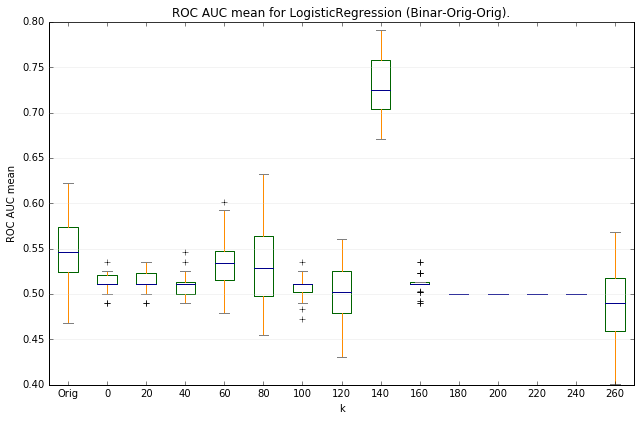

In [7]:
print_boxplot('LR/binar_eig_test_13.csv', 'Binar-Orig-Orig')